In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
%matplotlib inline

### Bulle SPARC_T4c_GCaMP_Grating data

In [3]:
Bulle_SPARC_T4cGcamp_grating_data = pd.read_csv("data/Bulle/Sparc_GCaMP_Grating_TimeSeries.txt",sep="\t")
column = ['time']
velocity = [15, 30, 60, 120]
[column.extend(['Mean_PD_'+str(velocity[i]),'SEM_PD_'+str(velocity[i])]) for i in range(len(velocity))];
#[column.extend(['Mean_ND_'+str(velocity[i]),'SEM_ND_'+str(velocity[i])]) for i in range(len(velocity))];
Bulle_SPARC_T4cGcamp_grating_data.columns = column
#Bulle_T4cGcamp_grating_data

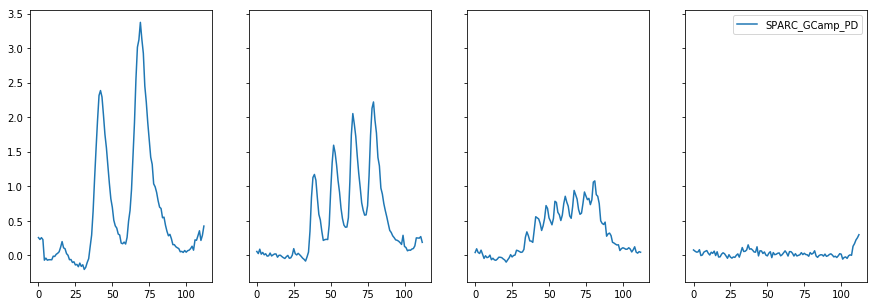

In [4]:
f, ax = plt.subplots(1,4, sharey=True, figsize=(15,5))
[ax[i].plot(Bulle_SPARC_T4cGcamp_grating_data['Mean_PD_'+str(velocity[i])], label='SPARC_GCamp_PD') for i in range(4)];
#[ax[i].plot(Bulle_T4cGcamp_grating_data['Mean_ND_'+str(velocity[i])], color='red', label='GCamp_ND') for i in range(4)];
plt.legend();
plt.savefig('figures/Bulle_SPARC_Grating.pdf', dpi = 1000)

### Bulle ArcLight_T4c_Grating data

In [5]:
Bulle_arclight_grating_data = pd.read_csv("data/Bulle/ArcLight_Grating_TimeSeries.txt",sep="\t")
column = ['time']
velocity = [15, 30, 60, 120]
[column.extend(['Mean_PD_'+str(velocity[i]),'SEM_PD_'+str(velocity[i])]) for i in range(len(velocity))];
[column.extend(['Mean_ND_'+str(velocity[i]),'SEM_ND_'+str(velocity[i])]) for i in range(len(velocity))];
Bulle_arclight_grating_data.columns = column
#Bulle_arclight_grating_data

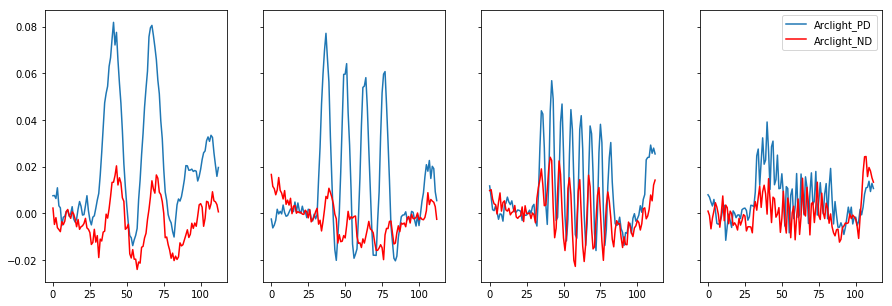

In [6]:
f, ax = plt.subplots(1,4, sharey=True, figsize=(15,5))
[ax[i].plot(Bulle_arclight_grating_data['Mean_PD_'+str(velocity[i])], label='Arclight_PD') for i in range(4)];
[ax[i].plot(Bulle_arclight_grating_data['Mean_ND_'+str(velocity[i])], color='red', label='Arclight_ND') for i in range(4)];
plt.legend();
plt.savefig('figures/Bulle_ArcLightGrating.pdf', dpi = 1000)

#### Model (threshold, lowpass filter, gain)

In [7]:
def lowpass_filter(x, tau=0.550,dt=0.01):
    y = np.zeros(len(x))
    alpha = dt / (tau+dt)
    y[0] = x[0]
    for i in np.arange(1,len(y)):
        y[i] = alpha*x[i] + (1-alpha)*y[i-1]
        
    return y

def threshold_cut(x, thres=0):
    x[x<thres] = 0
    return x

In [8]:
def Ca_model(x, tau=0.550, dt=0.0769, thres=0.0, gain=1.0):
    x_thres = threshold_cut(x, thres)
    x_thres_lowpass = lowpass_filter(x_thres, tau, dt)
    x_thres_lowpass_gain = gain*x_thres_lowpass
    
    return x_thres_lowpass_gain

In [9]:
def error_calc(x, y):
    err = (np.nanmax(x) - np.nanmax(y))**2
    return err

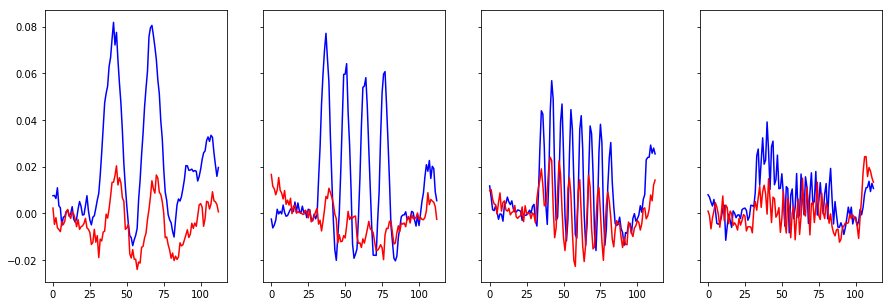

In [10]:
velocity = [15, 30, 60, 120]
df_arclight = Bulle_arclight_grating_data.copy()
thres = 0.0; tau = 0.3; gain = 120; dt = df_arclight.iloc[7]['time'] - df_arclight.iloc[6]['time']
f, ax = plt.subplots(1,4, sharey=True, figsize=(15,5))
[ax[i].plot(df_arclight['Mean_PD_'+str(velocity[i])],'b') for i in range(4)];
[ax[i].plot(df_arclight['Mean_ND_'+str(velocity[i])], 'r') for i in range(4)];

In [213]:
#velocities used for error calculation
velocity = [15, 30, 60, 120]; stim=[]
#[stim.extend(['Mean_PD_'+str(velocity[i]),'Mean_ND_'+str(velocity[i])]) for i in range(len(velocity))];
[stim.extend(['Mean_PD_'+str(velocity[i])]) for i in range(len(velocity))];
print (stim)

['Mean_PD_15', 'Mean_PD_30', 'Mean_PD_60', 'Mean_PD_120']


In [214]:
def shift_signal(x_model, x_data, vel):
    if vel == 15.0:
        shift = x_model.iloc[60:90].idxmax() - x_data.iloc[60:90].idxmax()
        return shift
    elif vel == 30.0:
        shift = x_model.iloc[70:90].idxmax() - x_data.iloc[70:90].idxmax()
        return shift
    elif vel == 60.0:
        shift = x_model.iloc[79:90].idxmax() - x_data.iloc[79:90].idxmax()
        return shift
    elif vel == 20.0: #for 120.0 deg/sec
        shift = x_model.iloc[20:50].idxmax() - x_data.iloc[20:50].idxmax()
        return shift

In [220]:
thres = np.linspace(-0.04, 0.06, 10)
tau =np.linspace(0.05,2.5,10)
gain = np.linspace(30.0, 100.0, 10)
error = np.zeros((len(thres), len(tau), len(gain)))
for i in range(len(thres)):
    for j in range(len(tau)):
        for k in range(len(gain)):
            err_= 0
            for sti in stim:
                PD_Gcamp_data = Bulle_SPARC_T4cGcamp_grating_data[sti].copy()
                PD_arclight = df_arclight[sti].copy()
                PD_Gcamp_model = pd.Series(Ca_model(PD_arclight.copy(), tau[j], dt, thres[i], gain[k]))
                shift = shift_signal(PD_Gcamp_model, PD_Gcamp_data, float(sti[-2:]))
                PD_Gcamp_model.index = PD_Gcamp_model.index - shift
                err_ += mean_squared_error(PD_Gcamp_model.loc[20:90].values, PD_Gcamp_data.loc[20:90].values)
            error[i, j, k] = err_/len(stim)
error.min()

0.09015415771326932

In [221]:
thres_model = thres[np.argwhere(error == np.min(error))[0][0]]
tau_model = tau[np.argwhere(error == np.min(error))[0][1]]
gain_model = gain[np.argwhere(error == np.min(error))[0][2]]
thres_model, tau_model, gain_model 

(0.026666666666666665, 0.5944444444444446, 45.55555555555556)

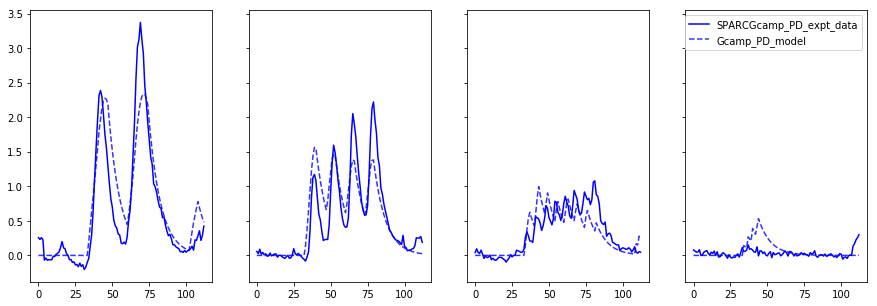

In [222]:
velocity = [15, 30, 60, 120]
f, ax = plt.subplots(1,4, sharey=True, figsize=(15,5))
[ax[i].plot(Bulle_SPARC_T4cGcamp_grating_data['Mean_PD_'+str(velocity[i])],'b',
            label='SPARCGcamp_PD_expt_data') for i in range(4)];
[ax[i].plot(Ca_model(df_arclight['Mean_PD_'+str(velocity[i])].copy(),
                    tau_model, dt, thres_model, gain_model), 'b--', label='Gcamp_PD_model', alpha=0.8) for i in range(4)];

# [ax[i].plot(Bulle_SPARC_T4cGcamp_grating_data['Mean_ND_'+str(velocity[i])],'r',
#             label='SPARCGcamp_ND_expt_data') for i in range(4)];
# [ax[i].plot(Ca_model(df_arclight['Mean_ND_'+str(velocity[i])].copy(),
#                      tau_model, dt, thres_model, gain_model), 'r--', label='Gcamp_ND_model', alpha=0.8) for i in range(4)];
plt.legend();
plt.savefig('figures/SPARC_Grating_Model.pdf', dpi = 1000)

In [223]:
#velocities used for error calculation
velocity = [15, 30, 60, 120]; stim=[]
#[stim.extend(['Mean_PD_'+str(velocity[i]),'Mean_ND_'+str(velocity[i])]) for i in range(len(velocity))];
[stim.extend(['Mean_PD_'+str(velocity[i])]) for i in range(len(velocity))];
print (stim)

['Mean_PD_15', 'Mean_PD_30', 'Mean_PD_60', 'Mean_PD_120']


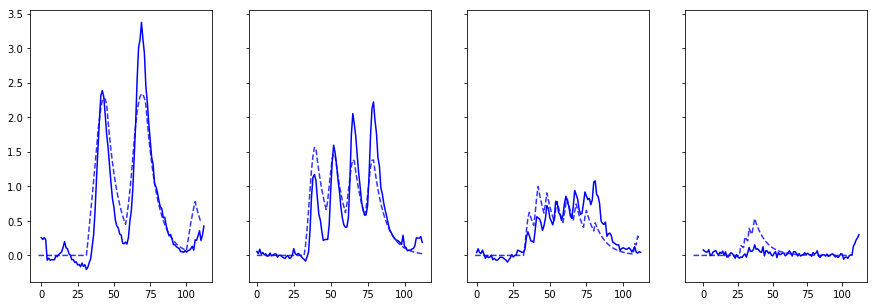

In [225]:
f, ax = plt.subplots(1,4, sharey=True, figsize=(15,5))
for i in range(len(stim)):
    sti=stim[i]
    PD_Gcamp_data = Bulle_SPARC_T4cGcamp_grating_data[sti].copy()
    PD_arclight = df_arclight[sti].copy()
    PD_Gcamp_model = pd.Series(Ca_model(PD_arclight.copy(), tau_model, dt, thres_model, gain_model))
    shift = shift_signal(PD_Gcamp_model, PD_Gcamp_data, float(sti[-2:]))
    PD_Gcamp_model.index = PD_Gcamp_model.index - shift
    ax[i].plot(PD_Gcamp_data,'b', label='SPARCGcamp_PD_expt_data')
    ax[i].plot(PD_Gcamp_model, 'b--', label='Gcamp_PD_model', alpha=0.8)

In [99]:
float(sti[-2:])

60.0

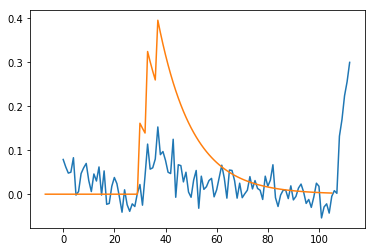

In [156]:
sti = 'Mean_PD_120'
PD_Gcamp_data = Bulle_SPARC_T4cGcamp_grating_data[sti].copy()
PD_arclight = df_arclight[sti].copy()
PD_Gcamp_model = pd.Series(Ca_model(PD_arclight.copy(), 1., dt, 0.03, 70))
shift = PD_Gcamp_model.iloc[20:55].idxmax() - PD_Gcamp_data.iloc[20:55].idxmax()
PD_Gcamp_model.index = PD_Gcamp_model.index - shift
plt.plot(PD_Gcamp_data)
plt.plot(PD_Gcamp_model);

In [157]:
PD_Gcamp_model.iloc[20:60].idxmax(), PD_Gcamp_data.iloc[20:60].idxmax()

(37, 37)

In [158]:
PD_Gcamp_model.iloc[60:90].idxmax(), PD_Gcamp_data.iloc[60:90].idxmax()

(53, 82)

In [22]:
PD_Gcamp_model - PD_Gcamp_data

-3           NaN
-2           NaN
-1           NaN
 0     -0.258000
 1     -0.231000
 2     -0.257000
 3     -0.229000
 4      0.069000
 5      0.039000
 6      0.069000
 7      0.062000
 8      0.062000
 9      0.063000
 10     0.011000
 11     0.015000
 12    -0.016000
 13    -0.031000
 14    -0.053000
 15    -0.119000
 16    -0.200000
 17    -0.110000
 18    -0.096000
 19    -0.026000
 20    -0.002000
 21     0.062000
 22     0.059000
 23     0.102000
 24     0.092000
 25     0.138000
 26     0.130000
          ...   
 83     0.539803
 84     0.586770
 85     0.496952
 86     0.538905
 87     0.557217
 88     0.557505
 89     0.476414
 90     0.483614
 91     0.517799
 92     0.469684
 93     0.455005
 94     0.428516
 95     0.401990
 96     0.412215
 97     0.373995
 98     0.358146
 99     0.301501
 100    0.298901
 101    0.408658
 102    0.530075
 103    0.618753
 104    0.699524
 105    0.859529
 106    0.643724
 107    0.587690
 108    0.463085
 109    0.338594
 110         N

In [41]:
((PD_Gcamp_model.loc[30:90]-PD_Gcamp_data.loc[30:90])**2).mean()

0.5493068580035284

In [42]:
from sklearn.metrics import mean_squared_error
mean_squared_error(PD_Gcamp_model.loc[30:90].values, PD_Gcamp_data.loc[30:90].values)

0.5493068580035283

In [94]:
from scipy import signal
corr_signal = signal.correlate(PD_Gcamp_data, PD_Gcamp_model)
shift = np.argmax(corr_signal) - len(PD_Gcamp_data)
shift


4

In [95]:
PD_Gcamp_data.index = PD_Gcamp_data.index - shift

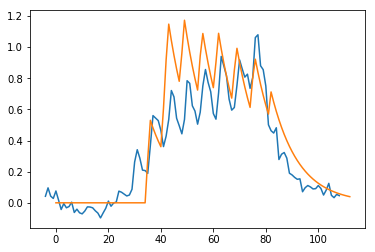

In [96]:
plt.plot(PD_Gcamp_data)
plt.plot(PD_Gcamp_model);

In [85]:
np.argmax(PD_Gcamp_data), np.argmax(PD_Gcamp_model)

(72, 72)

In [77]:
PD_Gcamp_data.index = PD_Gcamp_data.index - shift

In [83]:
PD_Gcamp_data.index 

RangeIndex(start=3, stop=116, step=1)

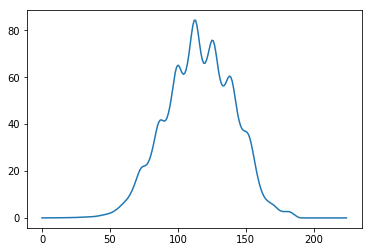

In [91]:
plt.plot(corr_signal)

In [198]:
thres = np.linspace(-0.04, 0.06, 10)
tau =np.linspace(0.5,3.0,20)
gain = np.linspace(50.0, 200.0, 20)
error = np.zeros((len(thres), len(tau), len(gain)))
for i in range(len(thres)):
    for j in range(len(tau)):
        for k in range(len(gain)):
            err_= 0
            for sti in stim:
                PD_Gcamp_data = np.array(Bulle_SPARC_T4cGcamp_grating_data[sti])
                PD_arclight = np.array(df_arclight[sti])
                model_data = Ca_model(PD_arclight.copy(), tau[j], dt, thres[i], gain[k])
                err_ += error_calc(PD_Gcamp_data.copy(), model_data.copy())
            error[i, j, k] = err_/len(stim)
error.min()

0.011289348581630436

In [199]:
thres_model = thres[np.argwhere(error == np.min(error))[0][0]]
tau_model = tau[np.argwhere(error == np.min(error))[0][1]]
gain_model = gain[np.argwhere(error == np.min(error))[0][2]]
thres_model, tau_model, gain_model 

(0.03777777777777778, 0.763157894736842, 73.68421052631578)

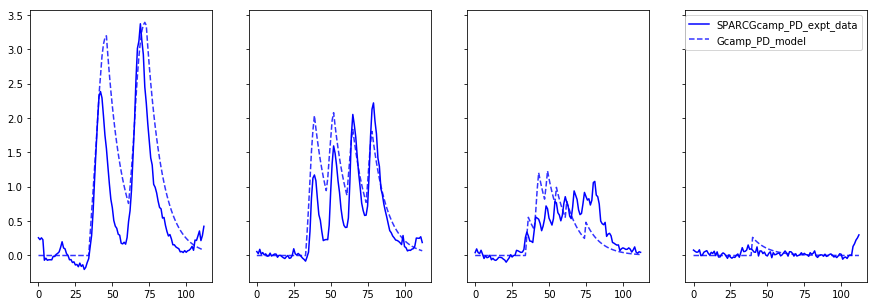

In [200]:
velocity = [15, 30, 60, 120]
f, ax = plt.subplots(1,4, sharey=True, figsize=(15,5))
[ax[i].plot(Bulle_SPARC_T4cGcamp_grating_data['Mean_PD_'+str(velocity[i])],'b',
            label='SPARCGcamp_PD_expt_data') for i in range(4)];
[ax[i].plot(Ca_model(df_arclight['Mean_PD_'+str(velocity[i])].copy(),
                    tau_model, dt, thres_model, gain_model), 'b--', label='Gcamp_PD_model', alpha=0.8) for i in range(4)];

# [ax[i].plot(Bulle_SPARC_T4cGcamp_grating_data['Mean_ND_'+str(velocity[i])],'r',
#             label='SPARCGcamp_ND_expt_data') for i in range(4)];
# [ax[i].plot(Ca_model(df_arclight['Mean_ND_'+str(velocity[i])].copy(),
#                      tau_model, dt, thres_model, gain_model), 'r--', label='Gcamp_ND_model', alpha=0.8) for i in range(4)];
plt.legend();
#plt.savefig('figures/SPARC_Grating_Model.pdf', dpi = 1000)